# Neural Networks Basics Pt. 2: Recurrent Neural Networks and LSTM

## Table of Contents

* [Recurrent Neural Networks (RNN)](#recurrent_neural_networks)
* [Long Short-Term Memory (LSTM)](#lstm)
* [RNN Example with *Keras/TensorFlow*](#rnn_with_keras_tensorflow)
    * [Data Preparation: Text Cleaning, Tokenization and Normalization](#data_preparation_1)
    * [Data Preparation: Creation of Text Sequences](#data_preparation_2)
    * [Data Preparation: Vectorization](#data_preparation_3)
    * [Model Creation, Compiling, and Fitting](#model_creation)
    * [Token Generation and Model Comparisons](#token_generation)
    * [Text Generation](#text_generation)
* [Sources](#sources)

## Recurrent Neural Networks (RNN) <a id="recurrent_neural_networks"></a>

**Recurrent neural networks** are **bi-directional** artificial neural networks which means that the output of some nodes can affect subsequent input to the same nodes, i.e., information from previous inputs are used to influence current inputs and outputs. While "traditional" neural networks are built on the assumption that all inputs and outputs are independent of each other, RNNs make use of **sequential information**. Therefore, common applications for RNNs include:

* **Speech recognition**: recognizing and transcribing spoken language
* **Time series prediction** (e.g., financial forecasting)
* **Video analysis** (e.g., action and gesture recognition, tracking moving objects in videos) and **text-to-video**
* **Anomaly detection** in sequential data
* **Recommender systems**

While the concept of an adaptive RNN has been propagated since the 1970s ([Hopfield network](https://en.wikipedia.org/wiki/Hopfield_network)), RNN architectures became the most popular solution to solve **natural language processing (NLP)** tasks from the mid-2000s onwards, especially after the advent of **[long short-term memory (LSTM)](#lstm)** networks. The concept of utilizing sequential data makes RNNs predestined for NLP tasks. For example, predicting the next word in a sentence requires knowledge of all words that came before this specific word. RNNs can solve tasks like this by performing the same task for every element of a sequence, with the **output being dependend on the previous outcomes**. This means that RNNs have a "memory" that caputures previously calculated information.<a name="footnote_ref-1"></a>[<sup>1</sup>](#footnote-1) In general, RNNs have the same input and output architecture as "traditional" feed-forward networks. However, the information flow from input to output is different as...

* the **weights remain the same** across the entire network (instead of utilizing different weight matrices for each hidden layer),<a name="footnote_ref-2"></a>[<sup>2</sup>](#footnote-2) and
* **recurrent units** introduce **cycles** through which the sequential information is passed.

<img src="./img/recurrent_neural_network.png" style="margin:auto"/>

RNNs handle sequential data by feeding the output of a previous step as input to the current step through these **cycles**. The previous inputs (i.e., the "memory") are "remembered" in the network's **hidden state** $s$ (also known as **memory state**) which utilizes **the same parameters on each input** across several time steps.<a name="footnote_ref-2"></a>[<sup>2</sup>](#footnote-2)<sup>,</sup> <a name="footnote_ref-3"></a>[<sup>3</sup>](#footnote-3) In this context, "time steps" do not refer to the actual passing of time, but to the position of a state $s$ within a sequence:

$$\underbrace{s^{(t-1)}}_{\text{past state}} \rightarrow \underbrace{s^{(t)}}_{\text{current state}} \rightarrow \underbrace{s^{(t+1)}}_{\text{future state}}$$

This results in a **recurrent computation** over the input sequence which can be unfolded into a directed acyclic computational graph. The recurrent unit receives two inputs:

1. The output of the previous layer $h^{(t-1)}$, and
2. an input at time step $x^{(t)}$.

Therefore, the **hidden state** $h$ within the recurrent unit can be represented by

$$h^{(t)} = f(h^{(t-1)}, x^{(t)}; \theta)$$

where $\theta$ represents the model's learnable parameters (i.e., weights and bias).<a name="footnote_ref-4"></a>[<sup>4</sup>](#footnote-4) The following image displays an unfolded RNN over three time steps, where $U$, $V$, and $W$ are weight matrices:<a name="footnote_ref-5"></a>[<sup>5</sup>](#footnote-5)

* $U$ = weight matrix for input-to-hidden connections
* $V$ = weight matrix for hidden-to-output connections
* $W$ = weight matrix for hidden-to-hidden connections

<img src="./img/recurrence_unfolded.png" style="margin:auto"/>

The forward propagation through the recurrent computation steps are similar to the ones in a "traditional" feedforward neural network with the goal to map an input sequence of $x$ values to a corresponding sequence of output values $o$:<a name="footnote_ref-5"></a>[<sup>5</sup>](#footnote-5)

1. Specifiction of the **initial state** $h^{(0)}$, e.g., by setting it to a non-zero value.
2. For each time step $t$ from $t = 1$:
    1. Calculate the **activation** $a^{(t)}$ by multiplying the previous hidden state with the hidden-to-hidden weight matrix $W$, multiplying the input $x$ with the weight matrix $U$, and adding the bias $b$:
    $$a^{(t)} = b + Wh^{(t-1)} + Ux^{(t)}$$
    
    2. Calculate the **hidden state** by applying **nonlinearity**, e.g., **tanh** (hyperbolic tangent, but other activation functions are possible, e.g., ReLU or sigmoid):
    $$h^{(t)} = \text{tanh}(a^{(t)})$$
    
    3. Calculate the **output** $o$, i.e., the unnormalized log probabilities for each possible value of the discrete variable, by multiplying the current hidden state $h^{(t)}$ with the hidden-to-output weight matrix $V$, and adding the bias $c$:
    $$o^{(t)} = c + Vh^{(t)}$$
    
    4. Calculate the normalized probabilities $\hat{y}^{(t)}$ of the output $o^{(t)}$ by passing the output through the softmax function:
    $$\hat{y}^{(t)} = \text{softmax}(o^{(t)})$$

This computation uses the same weights for each time step, which has two effects: (1) the model has fewer parameters to learn, and (2) the model is independent of the length of the input sequence.<a name="footnote_ref-6"></a>[<sup>6</sup>](#footnote-6)

<img src="./img/recurrent_neural_network_unfolded.png" style="margin:auto"/>

Now, the loss $L$ can be calculated. The **negative log likelihood** of a classification task maximizes the probability of choosing the correct category by minimizing the negative log likelihood, e.g., if the output probabilities of a model is
$$\hat{y} = [0.1, 0.3, 0.5, 0.1]$$

and the ground truth labels are
$$[0, 0, 0, 1]$$

the current model state likelihood is
$$0 \cdot 0.1 + 0 \cdot 0.3 + 0 \cdot 0.5 + 1 \cdot 0.1 = 0.1$$

The negative logarithm of the state likelihood is calculated for numeric stability (in case the numbers get very big or very small) and to achieve the maximization of the probability of choosing the correct category. If the negative log likelihood is minimizied, this probability increases (which is also consistend with the idea of a model getting better as the loss function approaches 0):
$$-\text{log}(0.1) = 2.3$$

If – for the same example – the ground truth labels would be 
$$[0, 0, 1, 0]$$

the negative log likelihood is
$$\begin{align}
0 \cdot 0.1 + 0 \cdot 0.3 + 1 \cdot 0.5 + 0 \cdot 0.1 &= 0.5 \\
-\text{log}(0.5) &= 0.69
\end{align}$$

which means that the loss is lower and therefore, the probability of predicting the correct class is higher.<a name="footnote_ref-7"></a>[<sup>7</sup>](#footnote-7) This loss can be calculated for each time step. Therefore, the total loss $L$ for a sequence of $x$ values paired with a squence of $y$ values is the sum of all losses over all time steps:

$$L = - \sum_{t} \text{log } p_{\text{model}} \left( y^{(t)} | \{ x^{(1)}, \ldots, x^{(t)} \} \right) $$

where $y^{(t)}$ is the entry from the output vector $\hat{y}^{(t)}$ that corresponds to the respective value $x$.<a name="footnote_ref-8"></a>[<sup>8</sup>](#footnote-8) The **multiclass cross entropy loss** is a different interpretation of the same formula:<a name="footnote_ref-9"></a>[<sup>9</sup>](#footnote-9)

$$L = - \sum_{t} y^{(t)} \text{log }\hat{y}^{(t)}$$

Computing the gradient of the loss function for an RNN works similar to a "traditional" feed-forward network: first, the forward propagation is computed, followed by the backward propagation. This operation is called **backpropagation through time (BPTT)**. The goal is to adjust the weights $U$, $V$, and $W$ in a way that minimizes the error of the RNN's output $\hat{y}$ in comparison to the expected output $y$. This is achieved by calculating the **derivatives** $\partial$ of the error (i.e., the **gradient**) with respect to the RNN's weights and bias.<a name="footnote_ref-10"></a>[<sup>10</sup>](#footnote-10)<sup>, </sup><a name="footnote_ref-11"></a>[<sup>11</sup>](#footnote-11) The following terms affect the change in the weights when considering a single time step:<a name="footnote_ref-12"></a>[<sup>12</sup>](#footnote-12)

* Change in the loss $L$ with respect to the change in the normalized prediction of the current output $\hat{y}^{(t)}$: $\frac{\partial L}{\partial \hat{y}^{(t)}}$
* Change in the normalized prediction for the current time step $\hat{y}^{(t)}$ with respect to the change in the current hidden state $h^{(t)}$: $\frac{\partial \hat{y}^{(t)}}{\partial h^{(t)}}$
* Change in the current hidden state $h^{(t)}$ with respect to the previous hidden state $h^{(t-1)}$: $\frac{\partial h^{(t)}}{\partial h^{(t-1)}}$
* Change in the previous hidden state with respect to the change in the weigts ($U$, $V$, or $W$): $\frac{\partial h^{(t-1)}}{\partial W}$

By application of the **chain rule**, the gradients can now be calculated. Since the RNN computes multiple time steps, the **gradients of all time steps** must be summed up for each weight and bias adjustment:<a name="footnote_ref-12"></a>[<sup>12</sup>](#footnote-12)<sup>, </sup><a name="footnote_ref-13"></a>[<sup>13</sup>](#footnote-13)

* Gradient for the input-to-hidden weight matrix $U$: $\frac{\partial L}{\partial U}$ (the gradients of the hidden states are accumulated through time by multiplying the sequence)
$$\frac{\partial L}{\partial U} = \sum^{t}_{i=0} \frac{\partial L}{\partial \hat{y}^{(t-i)}} \frac{\partial \hat{y}^{(t-i)}}{\partial h^{(t-i)}} \left( \prod^{t}_{j=t-i+1} \frac{\partial h^{(t-j+1)}}{\partial h^{(t-j)}} \right) \frac{\partial h^{(t-i-1)}}{\partial U}$$

* Gradient for the hidden-to-hidden weight matrix $W$: $\frac{\partial L}{\partial W}$ (the gradients of the hidden states are accumulated through time by multiplying the sequence)
$$\frac{\partial L}{\partial W} = \sum^{t}_{i=0} \frac{\partial L}{\partial \hat{y}^{(t-i)}} \frac{\partial \hat{y}^{(t-i)}}{\partial h^{(t-i)}} \left( \prod^{t}_{j=t-i+1} \frac{\partial h^{(t-j+1)}}{\partial h^{(t-j)}} \right) \frac{\partial h^{(t-i-1)}}{\partial W}$$

* Gradient for the hidden-to-output weight matrix $V$: $\frac{\partial L}{\partial V}$ (only the output $\hat{y}^{(t)}$ and the weights $V$ must be considered here)
$$\frac{\partial L}{\partial V} = \sum^{t}_{i=0} \frac{\partial L}{\partial \hat{y}^{(t-i)}} \frac{\partial \hat{y}^{(t-i)}}{\partial V}$$
    
* Gradient for the hidden layer bias $b$: $\frac{\partial L}{\partial b}$
$$\frac{\partial L}{\partial b} = \sum^{t}_{i=0} \frac{\partial L}{\partial \hat{y}^{(t-i)}} \frac{\partial \hat{y}^{(t-i)}}{\partial h^{(t-i)}} \frac{\partial h^{(t-i)}}{\partial b}$$

* Gradient for the output layer bias $c$: $\frac{\partial L}{\partial c}$
$$\frac{\partial L}{\partial c} = \sum^{t}_{i=0} \frac{\partial L}{\partial \hat{y}^{(t-i)}} \frac{\partial \hat{y}^{(t-i)}}{\partial c}$$

Afterwards, the weights and biases can be updated according to the gradient descent - the process is the same for all of them:<a name="footnote_ref-12"></a>[<sup>12</sup>](#footnote-12)
$$W \leftarrow W - \alpha \frac{\partial L}{\partial W}$$
where $\alpha$ is the **learning rate**.

However, BPTT is a computationally expensive operation as each state computed in the forward pass must be stored until it is reused in the backward propagation. Furthermore, this operation cannot be parallelized due to the sequential nature of the forward pass.<a name="footnote_ref-14"></a>[<sup>14</sup>](#footnote-14) Furthermore, RNNs are prone to two specific problems: **exploding and vanishing gradients**. **Exploding gradients** occur when the derivative values are high, leading to a strongly increasing gradient and consequently to oscilliating weights that are a sign of an unstable network behavior. If the gradient value grows extremely large, it can cause an overflow (i.e., *NaN*). Conversely, **vanishing gradients** occur when the derivative values are small. Due to the application of the chain rule, the gradient becomes increasingly small during the BPTT process, causing the gradient to vanish. In this case, training of the network takes a prohibitve amount of time or might not be possible at all. In general, the temporal evolution of the backpropagated error depends exponentially on the size of the weights.<a name="footnote_ref-15"></a>[<sup>15</sup>](#footnote-15) Overall, exploding and vanishing gradients lead to difficulties for the RNN to preserve and utilize information over many timesteps (also known as the **problem of long-term dependencies**, e.g., if context from a previous time step is required for predicting the current time step).

Various methods were proposed to overcome the exploding and vanishing gradient problem:
* **Batch normalization**, i.e., re-centering and re-scaling the inputs.
* Usage of **faster hardware** - especially the increase of computational power since the 1990s, e.g., in the form of increasingly faster GPUs - was able to somewhat mitigate the problem of vanishing gradients, albeit obviously not solving it.
* Usage of **rectifiers** (e.g., ReLU) as activation functions can mitigate vanishing gradients, as they only saturate in one direction.
* **Gradient clipping** is a method to counteract exploding gradients. If a gradient exceeds a certain threshold value, it is scaled to a smaller value.
* **Weight initialization** can counteract vanishing gradients if is not done randomly. Different methods have been proposed to achieve this.
* Over time, **modified RNN architectures** have been proposed. **Long short-term memory (LSTM)** specifically aims to deal with the vanishing gradient problem.

## Long Short-Term Memory (LSTM) <a id="lstm"></a>

**Long short-term memory** is a RNN architecture proposed in 1997 that specifically aims at solving the vanishing gradient problem. In contrast to RNNs, the ordinary recurrent nodes are replaced with **memory cells** that contain a **cell state** (also known as **internal state**). The LSTM is able to add or remove information to and from the cell state in a procedure that is regulated by strucutres called **gates**. The gates are multiplicative entities that determine the changes to the cell state, i.e., they **selectively** let information through. An LSTM cell consists of four components, each of which forms an individual network layer in the network topology, each with its own weights and bias:

* The aforementioned **cell state** $C$, the model's "long-term memory".
* A **forget gate** $F$ that determines whether to keep the current value of the memory.
* An **input gate** $I$ that determines how much of the input node's current value should be added to the current cell state.
* an **output gate** $O$ that determines whether the memory cell should influence the output at the current time step.

As with "regular" RNNs, the input to the memory cell consists of the current input $x^{(t)}$ and the hidden state of the previous time step $h^{(t-1)}$. The cell state is the LSTM's "long-term memory" in the sense that it encodes relevant information of the inputs from all previous time steps. It therefore differs from the hidden state, which only encodes information from the previous time step. The LSTM cell evaluates wheter information is "relevant" via its three gates.

The values of the three gates $F$, $I$, and $O$ are calculated by three fully-connected layers with a sigmoid activation function ($\sigma$). The sigmoid function returns values in the range of $(0, 1)$ that determine how much information should be kept of the information that passes through the gate.<a name="footnote_ref-16"></a>[<sup>16</sup>](#footnote-16)<sup>, </sup><a name="footnote_ref-17"></a>[<sup>17</sup>](#footnote-17)

<img src="./img/LSTM.png" style="margin:auto"/>

**Forward propagation** for LSTMs is similar to "regular" RNNs. Basically, all gate calculations are "standard" activation computations, i.e., multiply the input $x^{(T)}$ by its weights, multiply the previous hidden state $h^{(t-1)}$ by its weights, add both together, add the bias, and pass the result throught an activation function.<a name="footnote_ref-16"></a>[<sup>16</sup>](#footnote-16)<sup>, </sup><a name="footnote_ref-17"></a>[<sup>17</sup>](#footnote-17)<sup>, </sup><a name="footnote_ref-18"></a>[<sup>18</sup>](#footnote-18)

1. The first step is to **determine which of the cell state's information should be "forgotten"** by the forget gate. The forget gate uses a sigmoid activation function that returns a value between 0 and 1 for each element in the cell state $C^{(t-1)}$, where 0 means to completely "forget" the information and 1 stands for keeping it entirely:
$$F^{(t)} = \sigma (W_{hF} h^{(t-1)} + W_{xF} x^{(t)} + b_{F})$$

2. **New information is stored in the cell state**. This step consists of two parts:
    1. First, the input gate decides which values of the cell state should be updated by passing the weighted sum of the inputs through a sigmoid activation function:
    $$I^{(t)} = \sigma (W_{hI} h^{(t-1)} + W_{xI} x^{(t)} + b_{I})$$

    2. A tanh layer creates a vector of new candidate values $\tilde{C}^{(t)}$ to add to the cell state:
    $$\tilde{C}^{t} = \text{tanh}(W_{hC} h^{(t-1)} + W_{xC} x^{(t)} + b_{C})$$

3. The **old cell state $C^{(t-1)}$ is updated**: 
    1. First, the previous cell state is multiplied with the values from the forget gate to "forget" irrelevant information.
    2. Then, the outputs from the input gate $I^{(t)}$ and the candidate values $\tilde{C}^{(t)}$ are multiplied and the result is added to the cell state:
    $$C^{(t)} = F^{(t)} C^{(t-1)} + I^{(t)} \tilde{C}^{(t)}$$

4. Finally, the **output**, a filtered version of the cell state, **is calculated** in the output gate:
    1. A sigmoid function decides which parts of the cell states are going to be part of the output:
    $$O^{(t)} = \sigma (W_{hO} h^{(t-1)} + W_{xO} x^{(t)} + b_{O})$$
    
    2. The updated cell state is passed through a tanh function (which yields values beteen -1 and 1) and is multiplied with the output $O^{(t)}$:
    $$h^{(t)} = O^{(t)} \text{tanh}(C^{(t)})$$

This forward propagation is performed for each time step.

<img src="./img/LSTM_sequence.png" style="margin:auto"/>

## RNN Example with *Keras/TensorFlow* <a id="rnn_with_keras_tensorflow"></a>

The following example<a name="footnote_ref-19"></a>[<sup>19</sup>](#footnote-19) shows how to train an LSTM for text generation. In this example, the LSTM ist trained on J. W. von Goethe's *Faust I*. The trained RNN should generate some text in the style of Goethe (i.e., a sequence of 50 words) based on a random input text (i.e., the *seed text*). The text is available from various sources, such as [Project Gutenberg](https://www.gutenberg.org/cache/epub/63203/pg63203.txt) or [Wikisource](https://de.wikisource.org/wiki/Faust_-_Der_Trag%C3%B6die_erster_Teil).

The following packages are used to create and train the LSTM RNN:

In [1]:
%%capture --no-display

import tensorflow as tf
import numpy as np
import pandas as pd
import string
import json
import random
import matplotlib.pyplot as plt

The starting point for training a RNN to perform NLP-related tasks is a **corpus**, a text or a number of texts which forms the basis for the model's training. However, the corpus itself cannot be used for training in its text form, which is why some specific **data cleaning and pre-processing** tasks are necessary<a name="footnote_ref-20"></a>[<sup>20</sup>](#footnote-20)<sup>,</sup> <a name="footnote_ref-21"></a>[<sup>21</sup>](#footnote-21)<sup>,</sup> <a name="footnote_ref-22"></a>[<sup>22</sup>](#footnote-22) - the following are performed in this notebook:

* **Text cleaning**, i.e., the removal of certain parts of the text that should not be used for training.
* **Tokenization** is the process of splitting the text into smaller parts. The size of the tokens can be chosen depending on the use case, e.g., words, syllables, or letters. Tokenization also includes the removal of all punctuation signs, numbers, URLs, etc.
* **Normalization** of the tokens, e.g., by converting them all to lowercase.
* Building a **vocabulary**: the vocabulary is the set of individual words that appear in the corpus.

Other pre-processing tasks might include:

* **Stemming and lemmatization**: stemming refers to the process of reducing inflected words to their word stem (e.g., reducing the words *fishing*, *fished*, and *fisher* to the stem *fish*).<a name="footnote_ref-23"></a>[<sup>23</sup>](#footnote-23) Lemmatization is the process of grouping inflected words under their lemma (i.e., dictionary form), e.g., *walk*, *walked*, *walks* or *walking* are grouped under the base form *walk*.<a name="footnote_ref-24"></a>[<sup>24</sup>](#footnote-24)
* **Stopword removal**: stopwords are the most common words in a language that are deemed insignificant for the meaning of the text (e.g., *the*, *is*, *and*, *for*). Removing them from the vocabulary might result in a smaller data set and therefore enhanced training time.

### Data Preparation: Text Cleaning, Tokenization and Normalization <a id="data_preparation_1"></a>

First, we open the file and inspect the first and last 100 characters to see what the text looks like.

In [2]:
with open("./data/faust.txt", "r", encoding = "utf-8") as file:
    text = file.read()
    
print(text[:100])
print(50 * "-")
print(text[len(text) - 100:len(text)])

Faust:
Der Tragödie erster Teil

by Johann Wolfgang von Goethe


Contents

 Zueignung
 Vorspiel auf 
--------------------------------------------------
u Faust).
Her zu mir!
(Verschwindet mit Faust.)

STIMME (von innen, verhallend).
Heinrich! Heinrich!


The text contains some **introductory remarks** and a **table of contents** which we want to get rid of. The text starts with the first chapter heading "Zueignung", so we will take this word as the starting point. Since the chapter heading also appears in the table of contents, we are looking for the second occurrence of the word. The `find()` method returns the index of the first occurence of the specified string. It takes optional start and end parameters, so if we set the start to the first occurence of the word + 1, we can find the second occurence. The end of the text does not need any modification.

In [3]:
# Find the index of the second occurence of the "Zueignung" chapter heading
text_start = text.find("Zueignung", text.find("Zueignung") + 1)
# Reassign the text without table of contents
text = text[text_start:]
# Test - print the first 100 characters
print(text[:100])

Zueignung


Ihr naht euch wieder, schwankende Gestalten,
Die früh sich einst dem trüben Blick gezeig


Now, we want to **tokenize** the text. This means that we must **strip the text of any punctuation marks**, **split the text at each whitespace** into indiviual tokens, and normalize the tokens to **lowercase**. Python's `string` module contains various constants (e.g., `punctuation`), which could be used to remove the punctuation marks in the text. However, the text contains some punctuation marks that are not included in `punctuation`, which requires a custom solution. First, we identify all individual letters and punctuation marks from the text.

In [4]:
all_text_characters = []
for character in text:
    if character not in all_text_characters:
        all_text_characters.append(character)

print(sorted(all_text_characters))

['\n', ' ', '!', '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ä', 'Ö', 'Ü', 'ß', 'ä', 'ö', 'ü', '—', '’', '“', '”']


`printable` is a concatenation of all letters, digits, and punctuation marks constants from the `string` module:

In [5]:
# import string
print(string.printable)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



We can use `printable` to find additional punctuation marks in the text. The comparison also reveals that the text contains umlauts - unsurprisingly, as the text is German -, which obviously must remain in the text. To get rid of the punctuation marks, we append the additional ones to a list containg the `punctuation` characters. We use this list to replace every instance of the punctuation marks in the text with an empty string. We then split the entire text into individual tokens.

In [6]:
additional_punctuation = [i for i in all_text_characters if i not in string.printable]
print(additional_punctuation)

['ü', 'ä', 'ö', 'Ä', 'ß', '’', '—', '“', '”', 'Ü', 'Ö']


In [7]:
punctuation = [i for i in string.punctuation] + ['’', '—', '“', '”']
print(f"List of all punctuation marks: {punctuation}\n")

# Remove all punctuation marks
for p in punctuation:
    if p in text:
        text = text.replace(p, "")

# Split text into tokens
tokens = text.split()
# Normalize tokens by converting them to lowercase
tokens = [token.lower() for token in tokens]

# Print the first 10 tokens and some statistics
print(f"Token sample: {tokens[:10]}\n")
print(f"Total number of tokens: {len(tokens)}")
print(f"Number of unique tokens: {len(set(tokens))}")

List of all punctuation marks: ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '’', '—', '“', '”']

Token sample: ['zueignung', 'ihr', 'naht', 'euch', 'wieder', 'schwankende', 'gestalten', 'die', 'früh', 'sich']

Total number of tokens: 30591
Number of unique tokens: 6320


The previous analysis reveals that the **vocabulary** consists of 6320 words.

### Data Preparation: Creation of Text Sequences <a id="data_preparation_2"></a>

The next step is the creation of **text sequences** of 50 input words and 1 output word. To generate the sequences, we iterate over the text and save 51 words in a list. With each iteration, we move one word further to generate the sequences. The principle is illustrated in the following visualization:

```
Sequence 1: word1 word2 word3 word4 word5
Sequence 2:       word2 word3 word4 word5 word6
Sequence 3:             word3 word4 word5 word6 word7
                              etc.
```

In [8]:
# Define default sequence length
length = 50 + 1 # To illustrate 50 input words + 1 output
# Create empty list to store all sequences
sequences = []

# Iterate over the text to create the sequences
for i in range(length, len(tokens)):
    # Select sequence of tokens
    sequence = tokens[i - length:i]
    # Join tokens into a sequence
    line = " ".join(sequence)
    # Append sequence to sequence list
    sequences.append(line)
    
print(f"First sequence: \n{sequences[0]}")
print(50 * "-")
print(f"Last sequence: \n{sequences[-1]}")
print(f"\nTotal number of sequences: {len(sequences)}")

First sequence: 
zueignung ihr naht euch wieder schwankende gestalten die früh sich einst dem trüben blick gezeigt versuch ich wohl euch diesmal festzuhalten fühl ich mein herz noch jenem wahn geneigt ihr drängt euch zu nun gut so mögt ihr walten wie ihr aus dunst und nebel um mich steigt mein busen fühlt
--------------------------------------------------
Last sequence: 
dich mit ihr im stich margarete dein bin ich vater rette mich ihr engel ihr heiligen scharen lagert euch umher mich zu bewahren heinrich mir grauts vor dir mephistopheles sie ist gerichtet stimme von oben ist gerettet mephistopheles zu faust her zu mir verschwindet mit faust stimme von innen verhallend heinrich

Total number of sequences: 30540


The sequences are stored in a list of strings, with each string representing one sequence. The statistic shows that we have a total of 30,540 sequences. Finally, the sequences are **stored in a file** with each line containing one sequence to make the text corpus easier to use after data preparation.

In [9]:
with open("./data/faust_sequences.txt", "w", encoding = "utf-8") as file:
    file.write("\n".join(sequences))

### Data Preparation: Vectorization <a id="data_preparation_3"></a>

The final data preparation step is the **vectorization** of the tokens. Each sequence is transformed into a list of token indices, where each integer represents one word from the vocabulary. Vectorization is necessary create a numeric representation of the raw text that is suitable for machine learning. 

`TextVectorization` is a *Keras* layer that handles the vectorization of natural language inputs, i.e., it creates a mapping between the tokens and integer indices. This means that each token is assigned an integer index value based on the token's frequency in the vocabulary with the most common tokens being assigned the lowest integers. This is achieved by setting the `output_mode` argument to `int` when creating the `TextVectorization` layer.<a name="footnote_ref-25"></a>[<sup>25</sup>](#footnote-25) It is also capable of text normalization (via the `standardize` argument), but we have already done this in the previous step.

`TextVectorization` is one of four stateful *Keras* layers, meaning that it is **non-trainable** and that its state must be set **before training**. This internal state mainly consists of the vocabulary itself, the token frequencies, and various configuration parameters (e.g., maximum vocabulary size, output mode, etc.). The state is set by **adapting** the layer on the data via the `adapt()` method.<a name="footnote_ref-26"></a>[<sup>26</sup>](#footnote-26) By calling `adapt()`, the layer builds a **vocabulary** of all string tokens in the data set and performs the index mapping based on each token's frequency in the vocabulary. It is also possible to set a specific vocabulary size by specifying the `TextVectorization` layer's `max_tokens` argument. Typically, the index 0 is reserved for padding and index 1 is reserved for out-of-vocabulary tokens if a maximum vocabulary size is specified.

In [10]:
# Optional: load the previously saved sequences
#
# with open("./data/faust_sequences.txt", "r", encoding = "utf-8") as file:
#     text = file.read()
# 
# sequences = text.split("\n")
# print(sequences[0])

In [11]:
# Define the text vectorization layer
vectorizer = tf.keras.layers.TextVectorization(output_mode = "int")

# Build the vocabulary (i.e., adapt the text vectorization layer on the data)
vectorizer.adapt(sequences)

# Create the vectorized sequences
vectorized_sequences = vectorizer(sequences)

# Check the vectorized sequences
print(vectorized_sequences[0])
print(f"Length of the sequence: {len(vectorized_sequences[0])}")

tf.Tensor(
[6321   22 2312   33  105 2311 1448    4  573   20  836   28 2310  310
 6318 2308    3   57   33  488 2307  308    3   42  122   49  487  688
 6314   22  278   33    9   47   92   15 6312   22 6311   26   22   53
 2305    2  571   64   23  420   42  179  467], shape=(51,), dtype=int64)
Length of the sequence: 51


Next, we split the vectorized sequences into inputs (`X`) and outputs (`y`). The inputs are sequences of the first 50 words of the original sequences, and the output is the the 51st word. Splitting the squences results in two tensors: `X` with shape `(30540, 50)`, and `y` with shape `(30540,)`.

In [12]:
X, y = vectorized_sequences[:, : -1], vectorized_sequences[:, -1]

# Check input and output for the first sequence
print(f"Input X:\n{X[0]}\n\n"
      f"Length of the input X: {len(X[0])}\n\n"
      f"Output y: {y[0]}")

Input X:
[6321   22 2312   33  105 2311 1448    4  573   20  836   28 2310  310
 6318 2308    3   57   33  488 2307  308    3   42  122   49  487  688
 6314   22  278   33    9   47   92   15 6312   22 6311   26   22   53
 2305    2  571   64   23  420   42  179]

Length of the input X: 50

Output y: 467


Now, the outputs `y` must be **one-hot encoded** and we must define some of the model's parameters, namely the vocabulary size and the length of the input sequences. Since the previously created `vectorizer` is a *keras* `TextVectorization` object, we can use its `vocabulary_size()` method to determine the vocabulary size. The input sequence length is obtained dynamically from the second dimension of the input tensor's shape - this way, it must not be redefined in case the input sequence length changes. 

The one-hot encoding of `y` is done with *keras*' `to_categorical()` function. In this example, this will result in a tensor of shape `(30540, 6322)`. This means that this tensor contains 30540 encodings (one for each sequence) of length 3622 (i.e., the entire size of the vocabulary). The encoded sequences consists only of zeros with the 51st word of the preceding input sequence being encoded as 1 at it's position in the vocabulary.

If we take the sequence "*this is a test*" as an example, the vectorized sequence would be something like `[2 4 5 3]`. If the input `X` is "*this is a*" and the output `y` is "*test*", the output would be one-hot encoded according to its position in the vocabulary as follows: `[0, 1, 0, 0]`.

In [13]:
# Specify the vocabulary size
vocab_size = vectorizer.vocabulary_size()
# Specify the length of the input sequence X
seq_length = X.shape[1]

print(f"Vocabulary size: {vocab_size}")
print(f"Input sequence length: {seq_length}")

# One-hot encoding of the outputs y
y = tf.keras.utils.to_categorical(y, num_classes = vocab_size)
# Check the one-hot encoded outputs
print(f"Example of the first one-hot encoding: {y[0]}")
print(f"Shape of the one-hot encoded tensor y: {y.shape}")

Vocabulary size: 6322
Input sequence length: 50
Example of the first one-hot encoding: [0. 0. 0. ... 0. 0. 0.]
Shape of the one-hot encoded tensor y: (30540, 6322)


### Model Creation, Compiling, and Fitting <a id="model_creation"></a>

Finally, we can create, compile, and fit the model. First, we create a sequential model object by using *Keras*' `Sequential` class and add the following layers:

1. An **Embedding** layer that takes the vectorized tokens and maps the integer indices to a dense vector of fixed length whose size is specified with the `output_dim` argument. The dense vectors are initialized randomly and learned during training. They contain information about a word's meaning and its relationship to other words as similar words have similar dense vector representations. Since they are lower-dimensional than one-hot vectors (as specified by the `output_dim` argument), they are more leightweight and take up less space, and models can make better predictions.
2. An **LSTM** layer with 100 units to process the sequence data and capture long-term dependencies between the tokens. By setting `return_sequences` to `True`, the layer returns the full sequence instead of only returning the last output. This is required to return a three-dimensional input for the next LSTM layer.<a name="footnote_ref-27"></a>[<sup>27</sup>](#footnote-27) The dropout helps to regularize the model and prevent overfitting by randomly omitting 20% of the recurrent connections within the LSTM layer for each timestep during the training process.
3. A second **LSTM** layer with 100 units to process the sequences from the first LSTM layer. Since return_sequences is set to `False` by default, this layer returns only the last hidden state (i.e., a single output).
4. A **dropout** layer that randomly drops 20% of the units (i.e., the second LSTM layer's outputs) before passing the output to the next layer.
5. A fully connected **dense layer** that applies a linear transformation based on its own weight matrix and passes its result through a ReLU activation function. This helps to fine-tune the LSTM's output, or, in other words, helps to interpret the features extracted from the sequence.
6. A **dense** output layer which returns a probability distribution over all words in the vocabulary, i.e., each value represents the probability of a particular word to be the next token in the sequence. This is achieved by passing the output through the softmax activation function.

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = 100, input_length = seq_length))
model.add(tf.keras.layers.LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.2))
model.add(tf.keras.layers.LSTM(units = 100))
model.add(tf.keras.layers.Dropout(rate = 0.2))
model.add(tf.keras.layers.Dense(units = 100, activation = "relu"))
model.add(tf.keras.layers.Dense(units = vocab_size, activation = "softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           632200    
                                                                 
 lstm (LSTM)                 (None, 50, 100)           80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 6322)              638522    
                                                                 
Total params: 1441622 (5.50 MB)
Trainable params: 144162

The model is **compiled** (i.e., configured) with the `compile` method. It takes several arguments, of which the following will be used in this example:

* `optimizer`: the algorithm/method used to adjust the weights after each batch or epoch. [Various algorithms](https://www.kaggle.com/code/residentmario/keras-optimizers/notebook) are available out of the box.
* `loss`: the loss function to be used by the model.
* `metrics`: a list of the metrics used to evalueate the model performance.

In [15]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"])

Finally, the model is **fitted** (i.e., trained) with the `fit` method. Besides the input `X` and the output `y`, this method takes two **hyperparameters** that have a significant effect on the training process and the quality of the model:<a name="footnote_ref-28"></a>[<sup>28</sup>](#footnote-28)

* During one **epoch**, the entire training data set is being passed through the training algorithm. Therefore, the number of epochs determine how often the algorithm works through the entire data set.
* The **batch size** determines the number of examples the algorithm works through before it updates the model's internal parameters.

These two hyperparameters have a profound effect on the learning process, training time, and model quality:<a name="footnote_ref-29"></a>[<sup>29</sup>](#footnote-29)
* When choosing **too few epochs**, the model won't be able to learn patterns in the data and it will underfit. Conversely, choosing **too many epochs** might lead to overfitting
* When choosing a **smaller batch size**, the model performs more updates per epoch and the model tends to converge faster. However, the gradients might be noisier as the weights adjustment tends to be more "extreme". Small batch sizes also require less memory. When choosing a **larger batch size**, the model performs less updates per epoch, leading to more stable gradient updates and faster training times. However, this might lead to overfitting and it requires more memory.

In the following block of code, the batch size is set to 128 and the number of epochs is set to one to keep the training time to a minimum. However, this reduced training results in a bad model. To get some comparability on the effect of changing batch sizes and epochs, multiple models have been trained on the same data with different hyperparameter combinations. These combinations have significant differences in their training times, and the quality of their predictions will be assessed below.

| Model   | No. of epochs | Batch size | Approximate training time          |
| ---     | ---           | ---        | ---                                |
| Model 1 | 50            | 64         | ~ 63 seconds/epoch = 53 minutes    |
| Model 2 | 50            | 128        | ~ 42 seconds/epoch = 35 minutes    |
| Model 3 | 50            | 256        | ~ 26 seconds/epoch = 22 minutes    |
| Model 4 | 100           | 64         | ~ 66 seconds/epoch = 1h 50 minutes |
| Model 5 | 100           | 128        | ~ 42 seconds/epoch = 1h 10 minutes |
| Model 6 | 100           | 256        | ~ 26 seconds/epoch = 37 minutes    |

In [16]:
history = model.fit(X, y, batch_size = 128, epochs = 1)

239/239 [==============================] - 47s 175ms/step - loss: 7.3192 - accuracy: 0.0262


The following block of code has been used to save the model and the training history (i.e., loss and accuracy after each epoch). 

In [17]:
# Specify path and file names
path = "./models/"
model_name = "x.keras"  # Enter file name for the model being saved
history_name = "x.json" # Enter file name for the history being saved

# Uncomment to save the model and training history
# Save the model
# model.save(f"{path}{model_name}")
# 
# # Save the training history
# with open(f"{path}{history_name}", "w") as file:
#     json.dump(history.history, file)

### Token Generation and Model Comparisons <a id="token_generation"></a>

We can now check how the model works by **generating a token based on a random sequence** (*seed text*) from the corpus. Since each sequence consists of 51 tokens (words), we can use the first 50 words to predict the 51st. First we load the pre-trained models.

In [18]:
# Load the models
path = "./models/"

model_1_filename = "model_1_50_epochs_batch_size_64.keras"
model_2_filename = "model_2_50_epochs_batch_size_128.keras"
model_3_filename = "model_3_50_epochs_batch_size_256.keras"
model_4_filename = "model_4_100_epochs_batch_size_64.keras"
model_5_filename = "model_5_100_epochs_batch_size_128.keras"
model_6_filename = "model_6_100_epochs_batch_size_256.keras"

model_1 = tf.keras.models.load_model(f"{path}{model_1_filename}")
model_2 = tf.keras.models.load_model(f"{path}{model_2_filename}")
model_3 = tf.keras.models.load_model(f"{path}{model_3_filename}")
model_4 = tf.keras.models.load_model(f"{path}{model_4_filename}")
model_5 = tf.keras.models.load_model(f"{path}{model_5_filename}")
model_6 = tf.keras.models.load_model(f"{path}{model_6_filename}")

We then load the **vocabulary** from the previously created `vectorizer` object. It is a list of all vocabulary words sorted by frequency. It is required to transform the integer index returned by the prediction back into an actual word by selecting the vocabulary word at the predicted index position.

In [19]:
vocab = vectorizer.get_vocabulary()
# Show a sample of the vocabulary
print(vocab[:20])

['', '[UNK]', 'und', 'ich', 'die', 'der', 'nicht', 'das', 'ein', 'zu', 'ist', 'du', 'in', 'sie', 'es', 'so', 'mephistopheles', 'den', 'mit', 'faust']


We can now check the model's predictions by generating a token based on a random sequence (*seed text*). This first requires a few steps to **prepare some test data**:

1. Pick 15 random sequences from the `sequences` list of sequences (i.e., the seed texts).
2. Vecotrize each seed text by using the previously created `vectorizer`. This results in a tensor of shape `(1, 51)`.
3. Slice the seed text tensor to only include the first 50 indices, and store the resulting tensor `X_test` of shape `(1, 50)` in a list.
4. Slice the seed text tensor again to obtain its 51st integer index. This results in a tensor of shape `(1, )`. Convert this tensor to a single integer and store it in a list. This is achieved by converting the the `y_test_int` tensor into a *numpy* array (`y_test_int.numpy()`), selecting the first (and only) element of the array, and converting it using the `int()` function.
5. Convert the integer index to its corresponding vocabulary word and append it to a list. The `if predicted_index < len(vocab) else "UNK"` part is not really required here. If the vocabulary would have been capped at a certain size, it would return `UNK` (short for "unknown") if an index larger than the vocabulary size would be returned.

In [20]:
# Set seed for reproducable results when generating the seed texts
random.seed(1)

# Select 15 random seed texts
seed_text_samples = random.sample(sequences, 15)

# Lists to store the transformed test data
vectorized_seed_texts = []
ground_truth_indices = []
ground_truth_tokens = []

# Vectorize each sample and extract the ground truth token
for sample in seed_text_samples:
    # Vectorize the seed text
    vectorized_seed_text = vectorizer([sample])
    # Slice the vectorized seed text tensor and assign its first 50 integer indices to X_test
    X_test = vectorized_seed_text[:, :-1]
    vectorized_seed_texts.append(X_test)
    
    # Slice the vectorized seed text tensor and assign the 51st integer index to y_test_int
    y_test_int = vectorized_seed_text[:, -1]
    y_test_int = int(y_test_int.numpy()[0])
    ground_truth_indices.append(y_test_int)
    
    # Convert the integer index to the actual token using the vocabulary
    y_test = vocab[y_test_int] if y_test_int < len(vocab) else "UNK"
    ground_truth_tokens.append(y_test)

# Print the first example
print(f"Seed text: \n{seed_text_samples[0]}\n")
print(f"Vectorized seed text tensor, shape {vectorized_seed_texts[0].shape}: \n{vectorized_seed_texts[0]}\n")
print(f"y_test integer index: {ground_truth_indices[0]}\ny_test vocabulary word: {ground_truth_tokens[0]}")

Seed text: 
gewesen was grinsest du mir hohler schädel her als daß dein hirn wie meines einst verwirret den leichten tag gesucht und in der dämmrung schwer mit lust nach wahrheit jämmerlich geirret ihr instrumente freilich spottet mein mit rad und kämmen walz und bügel ich stand am tor ihr solltet schlüssel sein

Vectorized seed text tensor, shape (1, 50): 
[[ 548   25 2002   11   21 4682 3482  202   41   39  136 1953   26 1843
   836 2794   17  940  119 5017    2   12    5 2166  260   18  235   51
   497 4545 5144   22 4597  469 1667   42   18 3828    2 4385 2703    2
  5822    3  592   69  430   22 1155  898]]

y_test integer index: 68
y_test vocabulary word: sein


Now we can **generate tokens based on the seed texts**. To get a glimpse on how the individual models perform, all 15 seed texts are fed into each model. Each model predicts an integer index based on the seed text which is converted into the corresponding word. These are the steps to obtain the integer indices:

1. Use the *keras* `predict` method to generate output predictions for the input samples. This returns a tensor of shape `(1, 6322)` which contains the probabilities for each word to be the next in the sequence. The vocabulary size is 6320, the additional two indices are added for padding (0) and out-of-vocabulary tokens (1). The actual vocabulary words start at index 2.
2. Call the *numpy* `argmax` function to find the token with the highest probability. It returns the position of the highest probability in the tensor, i.e., the integer index.
3. Look up the corresponding word in the vocabulary.

The results for each model are saved in a dictionary. The dictionary is then converted into a *pandas* dataframe to display the predictions against the ground truth.

In [21]:
models = [model_1, model_2, model_3, model_4, model_5, model_6]
# Dictionary to store the results of all models
model_predictions = {}
model_increment = 1

for model in models:
    # List to store each model's predicted token
    predictions = []
    
    for seed_text in vectorized_seed_texts:
        # Make a prediction
        yhat = model.predict(seed_text, verbose = 0)
        # Obtain the predicted index
        predicted_index = np.argmax(yhat, axis=-1)[0]
        # Map the predicted index to the corresponding word in the vocabulary
        predicted_word = vocab[predicted_index] if predicted_index < len(vocab) else "UNK"
        # Store the prediction in the list
        predictions.append(predicted_word)
    
    # Store all model predictions in the dictionary
    model_predictions[f"Model {model_increment}"] = predictions
    model_increment += 1

# Convert the dictionary to a dataframe and add a column with the ground truth tokens
results = pd.DataFrame.from_dict(model_predictions)
results["Ground Truth"] = ground_truth_tokens
# Show the results
results

,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Ground Truth
0,sein,kurzer,hat,sein,dazu,sein,sein
1,engen,glieder,hohe,sterne,sterne,gebohrt,sterne
2,fremde,innigem,famulus,denn,seit,gott,oberon
3,sich,mir,wir,faust,sich,ihn,uns
4,säuseln,zu,tritt,in,ist,nicht,dich
5,mich,nicht,nicht,dir,nicht,noch,euch
6,beiden,geist,pfarrer,der,ein,kräfte,der
7,pöbel,heftgen,welsche,pöbel,pöbel,pöbel,pöbel
8,diesem,diesem,den,eurer,jedem,dem,eurer
9,ich,ich,ich,ich,ich,es,ich


We can also calculate how many correct matches each model has predicted. The *pandas* `eq` method compares each model column against the *ground_truth* column and returns `True` or `False`, depending on whether the values match or not. We can then sum the results along the columns which will give us the number of matches since `True` is counted as 1.

In [22]:
comp = results.iloc[:, :-1].eq(results["Ground Truth"], axis = 0)
match_counts = comp.sum(axis = 0)
match_counts

Model 1    4
Model 2    3
Model 3    2
Model 4    9
Model 5    6
Model 6    4
dtype: int64

In addition, we can use the previously exported **training histories** do display the model's **loss and accuracy** numbers. First, the model histories are loaded and then plotted.

In [23]:
# Load the model histories
path = "./models/"
filenames = ["model_1_50_epochs_batch_size_64_history.json", "model_2_50_epochs_batch_size_128_history.json",
             "model_3_50_epochs_batch_size_256_history.json", "model_4_100_epochs_batch_size_64_history.json",
             "model_5_100_epochs_batch_size_128_history.json", "model_6_100_epochs_batch_size_256_history.json"]

model_histories = {}
for i, filename in enumerate(filenames, 1):
    with open(f"{path}{filename}", "r") as file:
        model_histories[f"model_{i}_history"] = json.load(file)

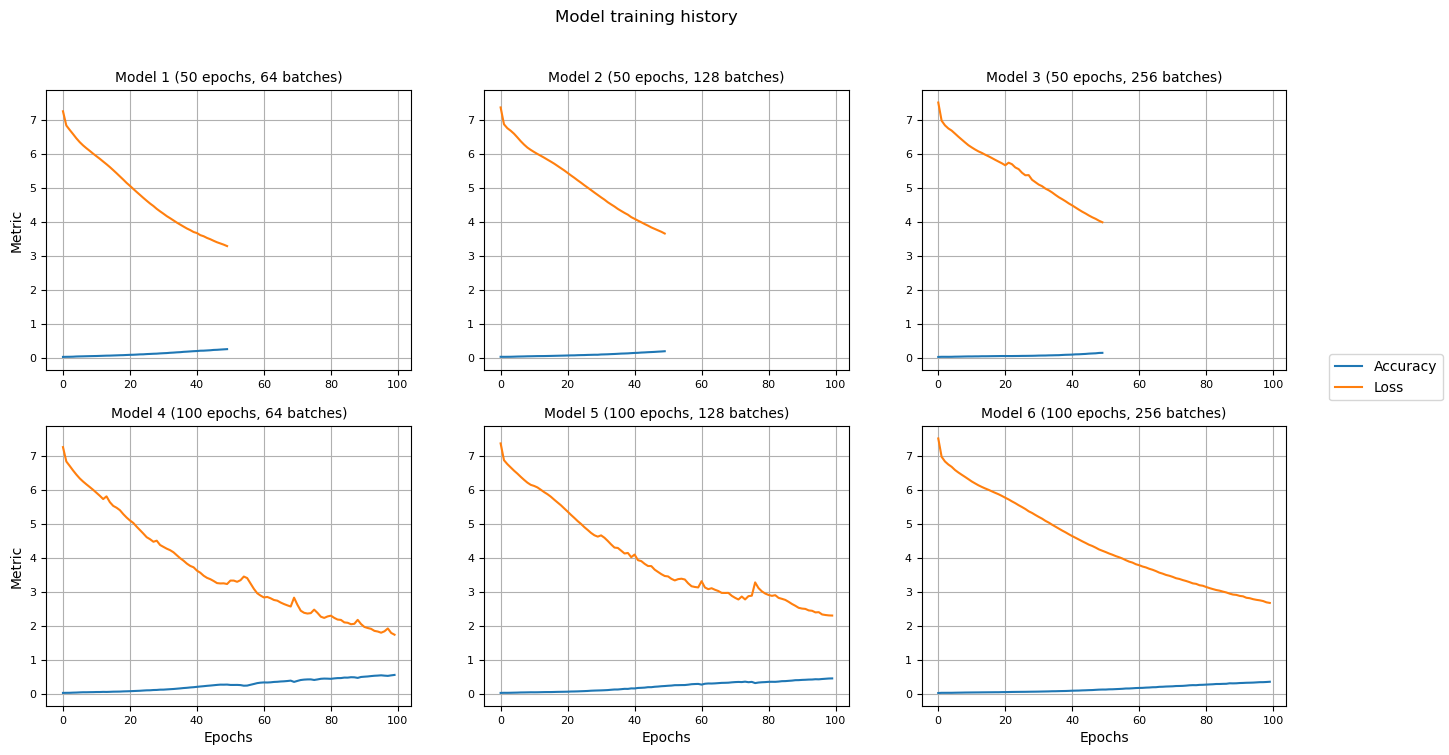

In [24]:
# Plot the model histories
# Save histories in a list
histories = []
for history in model_histories.values():
    histories.append(history)
# Create list with subplot titles
titles = ["Model 1 (50 epochs, 64 batches)", "Model 2 (50 epochs, 128 batches)", 
          "Model 3 (50 epochs, 256 batches)", "Model 4 (100 epochs, 64 batches)",
          "Model 5 (100 epochs, 128 batches)", "Model 6 (100 epochs, 256 batches)"]

# Create the chart with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, sharex = True, sharey = True)#, sharex=True, sharey=True)
axes = axes.flatten()
fig.set_figheight(8)
fig.set_figwidth(16)
fig.suptitle("Model training history", fontsize = 12)

# Loop through each model history create each subplot
for i, (model_history, title) in enumerate(zip(histories, titles)):
    axes[i].plot(model_history["accuracy"], label = "Accuracy")
    axes[i].plot(model_history["loss"], label = "Loss")
    axes[i].set_title(title, fontsize = 10)
    # Add x and y axis labels only for certain subplots
    if i >= 3:
        axes[i].set_xlabel("Epochs", fontsize = 10)
    if i in [0, 3]:
        axes[i].set_ylabel("Metric", fontsize = 10)
    axes[i].grid()

# Add axis ticks and numbers
for ax in axes:
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize = 8)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize = 8)

# Add legend
fig.legend(["Accuracy", "Loss"], loc="right")

plt.show()

The **loss metric** shows - especially for the models that have been trained for 100 epochs - that smaller batch sizes indeed lead to noisier gradients. Model 6 shows a smoother loss curve. However, the **accuracy metrics** are not really good for any model. Nonetheless, model 4 seems to be the best out of the ones trained as it has the highest accuracy and the lowest loss score. During the limited test run, it also made the most correct predictions with 60% of the generated tokens being correct.

### Text Generation <a id="text_generation"></a>

Finally, we can use one of the models to randomly generate a new masterpiece in the style of Goethe. Based on the limited testing above, it seems that **model 4** (100 epochs with a batch size of 64) **performs best**. New text is generating by using the seed text to predict the next token index. Then, the first index is removed from the seed text tensor and the predicted integer is appended to its end. The tensor - modified in this way - now forms the basis for the next prediction and so on.

In [25]:
# Pick a random seed text
seed_text = sequences[random.randint(0, len(sequences))]

# Vectorize the seed text
vectorized_seed_text = vectorizer([seed_text])

for i in range(51):
    # Make a prediction
    yhat = model_4.predict(vectorized_seed_text, verbose = 0)
    # Obtain the predicted index
    predicted_index = np.argmax(yhat, axis = -1)[0]
    # Remove the first index from the seed text tensor
    vectorized_seed_text = vectorized_seed_text[:, 1:]
    # Add the predicted index to the end of the seed text tensor
    vectorized_seed_text = tf.concat([vectorized_seed_text, [[predicted_index]]], axis = 1)

# Convert the seed text tensor to text
generated_text = []
for i in vectorized_seed_text:
    for j in i:
        word = vocab[j]
        generated_text.append(word) if predicted_index < len(vocab) else "UNK"

print(f"Seed text:\n{seed_text}\n")
print(f"Generated text:\n{' '.join(generated_text)}")

Seed text:
streben ich säh im ewigen abendstrahl die stille welt zu meinen füßen entzündet alle höhn beruhigt jedes tal den silberbach in goldne ströme fließen nicht hemmte dann den göttergleichen lauf der wilde berg mit allen seinen schluchten schon tut das meer sich mit erwärmten buchten vor den erstaunten augen auf doch

Generated text:
scheint die göttin endlich wegzusinken allein und weit hinzugehn und zehn ist keins das ist das hexeneinmaleins faust mich dünkt die alte weib hin da hinzugeben in und lindern der eine büchsen rings umstellt mit instrumenten duft und kriege das volle heilge römsche reich wie hälts nur nicht zusammen braut was


The generated text does not make much sense, but this is obviously due to the model's quality. It shows that the approach works well in principle, but more time (i.e., more epochs) is required to train the model in a way that achieves better results.

## Sources <a id="sources"></a>

<a name="footnote-1"></a><sup>1</sup> [Britz, D. (2015). *Recurrent Neural Networks Tutorial, Part 1 – Introduction to RNNs*.](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-1/) [$\uparrow$](#footnote_ref-1) <br>
<a name="footnote-2"></a><sup>2</sup> [GeeksforGeeks (2023). *Introduction to Recurrent Neural Network*.](https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/) [$\uparrow$](#footnote_ref-2) <br>
<a name="footnote-3"></a><sup>3</sup> [Goodfellow, I, Bengio, Y & Courville, A (2023). *Deep Learning*. MIT Press](https://www.deeplearningbook.org/contents/rnn.html), p. 368. [$\uparrow$](#footnote_ref-3) <br>
<a name="footnote-4"></a><sup>4</sup> [Goodfellow, I, Bengio, Y & Courville, A (2023). *Deep Learning*. MIT Press](https://www.deeplearningbook.org/contents/rnn.html), p. 368-372. [$\uparrow$](#footnote_ref-4) <br>
<a name="footnote-5"></a><sup>5</sup> [Goodfellow, I, Bengio, Y & Courville, A (2023). *Deep Learning*. MIT Press](https://www.deeplearningbook.org/contents/rnn.html), p. 374. [$\uparrow$](#footnote_ref-5) <br>
<a name="footnote-6"></a><sup>6</sup> [Stanford course CS224N - Natural Language Processing with Deep Learning (2019). *Language Models, RNN, GRU and LSTM*.](https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes05-LM_RNN.pdf) [$\uparrow$](#footnote_ref-6) <br>
<a name="footnote-7"></a><sup>7</sup> Example from [Tovar, A. D (2019). *Negative log likelihood expplained*.](https://medium.com/deeplearningmadeeasy/negative-log-likelihood-6bd79b55d8b6) [$\uparrow$](#footnote_ref-7) <br>
<a name="footnote-8"></a><sup>8</sup> [Goodfellow, I, Bengio, Y & Courville, A (2023). *Deep Learning*. MIT Press](https://www.deeplearningbook.org/contents/rnn.html), p. 374. [$\uparrow$](#footnote_ref-8) <br>
<a name="footnote-9"></a><sup>9</sup> [O'Reilly (2024). *Multi-class cross entropy loss*.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) [$\uparrow$](#footnote_ref-9) <br>
<a name="footnote-10"></a><sup>10</sup> [Brownlee, J. (2020). *A Gentle Introduction to Backpropagation Through Time*.](https://machinelearningmastery.com/gentle-introduction-backpropagation-time/) [$\uparrow$](#footnote_ref-10) <br>
<a name="footnote-11"></a><sup>11</sup> [Britz, D. (2015). *Recurrent Neural Networks Tutorial, Part 2 – Implementing a RNN with Python, Numpy and Theano*.](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-2/) [$\uparrow$](#footnote_ref-11) <br>
<a name="footnote-12"></a><sup>12</sup> [Sidhart (2023). *Backpropagation Through Time (BPTT): Explained With Derivations*.](https://www.pycodemates.com/2023/08/backpropagation-through-time-explained-with-derivations.html) [$\uparrow$](#footnote_ref-12) <br>
<a name="footnote-13"></a><sup>13</sup> [Britz, D. (2015). *Recurrent Neural Networks Tutorial, Part 3 – Backpropagation Through Time and Vanishing Gradients*.](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-3/) [$\uparrow$](#footnote_ref-13) <br>
<a name="footnote-14"></a><sup>14</sup> [Goodfellow, I, Bengio, Y & Courville, A (2023). *Deep Learning*. MIT Press](https://www.deeplearningbook.org/contents/rnn.html), p. 374-376. [$\uparrow$](#footnote_ref-14) <br>
<a name="footnote-15"></a><sup>15</sup> [Hochreiter, S., Schmidhuber, J. (1997), Long Short-Term Memory, *Neural Computation*, vol. 9(8), pp 1735–1780.](https://www.bioinf.jku.at/publications/older/2604.pdf) [$\uparrow$](#footnote_ref-15) <br>
<a name="footnote-16"></a><sup>16</sup> [Olah, C. (2015). *Understanding LSTM Networks*.](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) [$\uparrow$](#footnote_ref-16) <br>
<a name="footnote-17"></a><sup>17</sup> [Dive into Deep Learning. (2024). *Long Short-Term Memory (LSTM)*.](https://d2l.ai/chapter_recurrent-modern/lstm.html) [$\uparrow$](#footnote_ref-17) <br>
<a name="footnote-18"></a><sup>18</sup> [Feng, C. (2023). *Machine Learning Notebook*](https://calvinfeng.gitbook.io/machine-learning-notebook/supervised-learning/recurrent-neural-network/long_short_term_memory) [$\uparrow$](#footnote_ref-18) <br>
<a name="footnote-19"></a><sup>19</sup> Inspired by [Brownlee, J. (2020). *How to Develop a Word-Level Neural Language Model and Use it to Generate Text*.](https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/) [$\uparrow$](#footnote_ref-19) <br>
<a name="footnote-20"></a><sup>20</sup> [De Silva, M. (2023). *Preprocessing Steps for Natural Language Processing (NLP): A Beginner’s Guide*.](https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9) [$\uparrow$](#footnote_ref-20) <br>
<a name="footnote-21"></a><sup>21</sup> [Mayo, M. (2022). *Natural Language Processing Key Terms, Explained*.](https://www.kdnuggets.com/2017/02/natural-language-processing-key-terms-explained.html) [$\uparrow$](#footnote_ref-21) <br>
<a name="footnote-22"></a><sup>22</sup> [Ali Awan, A. (2023). *What is Tokenization?*.](https://www.datacamp.com/blog/what-is-tokenization) [$\uparrow$](#footnote_ref-22) <br>
<a name="footnote-23"></a><sup>23</sup> [Wikipedia (2024). *Stemming*.](https://en.wikipedia.org/wiki/Stemming) [$\uparrow$](#footnote_ref-23) <br>
<a name="footnote-24"></a><sup>24</sup> [Wikipedia (2023). *Lemmatization*.](https://en.wikipedia.org/wiki/Lemmatization) [$\uparrow$](#footnote_ref-24) <br>
<a name="footnote-25"></a><sup>25</sup> [TensorFlow Documentation (2024). *tf.keras.layers.TextVectorization*.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) [$\uparrow$](#footnote_ref-25) <br>
<a name="footnote-26"></a><sup>26</sup> [TensorFlow Documentation (2024). *Working with preprocessing layers - The adapt() method*.](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method) [$\uparrow$](#footnote_ref-26) <br>
<a name="footnote-27"></a><sup>27</sup> [Brownlee, J. (2019). *Difference Between Return Sequences and Return States for LSTMs in Keras*.](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/) [$\uparrow$](#footnote_ref-27) <br>
<a name="footnote-28"></a><sup>28</sup> [Brownlee, J. (2022). *Difference Between a Batch and an Epoch in a Neural Network*.](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) [$\uparrow$](#footnote_ref-28) <br>
<a name="footnote-29"></a><sup>29</sup> [Stack Overflow (2020). *Neural Network : Epoch and Batch Size*.](https://stackoverflow.com/questions/64493769/neural-network-epoch-and-batch-size) [$\uparrow$](#footnote_ref-29) <br>